In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa

from argparse import ArgumentParser
import random, sys, math, gzip, os
from tqdm import tqdm

sys.path.append('../')
from dataloader.nsynthdataset import NSynthDataSet
from util import util
from transformer.transformers import GTransformer

%load_ext autoreload
%autoreload 2

np.seterr(divide='ignore', invalid='ignore')
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [12]:
config = util.get_config('../config/config.json')
data_dir = config['data_dir']
sample_rate = config['sample_rate']
batch_size = config['batch_size']
lr = config['lr']
lr_warmup = config['lr_warmup']
epochs = config['epochs']

sample_length = config['sample_length']
embedding_size = config['embedding_size'] 
num_heads = config['num_heads']
depth = config['depth']
num_tokens = config['num_tokens']

lower_pitch_limit = config['lower_pitch_limit']
upper_pitch_limit = config['upper_pitch_limit']

In [3]:
model = GTransformer(emb=embedding_size, heads=num_heads, depth=depth, seq_length=sample_length, num_tokens=num_tokens, attention_type=None)
model = model.cuda()

opt = torch.optim.Adam(lr=lr, params=model.parameters())
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (lr_warmup / batch_size), 1.0))
loss = torch.nn.NLLLoss(reduction='mean')

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

3257088

In [5]:
print(model)
# model.token_embedding.register_forward_hook(lambda m, input, output: print(output))

GTransformer(
  (token_embedding): Linear(in_features=4, out_features=256, bias=True)
  (token_embedding_batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (token_embedding_activation): ReLU()
  (pos_embedding): Linear(in_features=128, out_features=256, bias=True)
  (pos_embedding_batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (pos_embedding_activation): ReLU()
  (tblocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (tokeys): Linear(in_features=256, out_features=256, bias=False)
        (toqueries): Linear(in_features=256, out_features=256, bias=False)
        (tovalues): Linear(in_features=256, out_features=256, bias=False)
        (unifyheads): Linear(in_features=256, out_features=256, bias=True)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff): Se

## Sampling
Sampling is done as follows -  
1. Select an input from the dataloader (update sample_index to any value from 0 to 15). Shape will be `1 X sample_length` or `1 X 512`
2. Generate the output from the model. Shape will be `1 X 512 X 256`
3. Retrieve the last sample from the 512 sample_length dimension `sample_data = sample_data[0, -1, :]` (argmax or temperature sampling (-- I need to understand this more--)  
4. Append this sample to the input (from step 1). Both input and this new sample are between 0 - 255. Use this as the new input and repeat from Step 1 for as long as you want (here we are iterating through the steps 256 times to generate 256 new samples).
5. Convert this 512 + 256 new samples to waveform using mu_expand from librosa.

In [6]:
def load_model(model, opt, model_location):
    checkpoint = torch.load(model_location)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    epoch = checkpoint['epoch']
    return model, opt, loss, epoch

def mulawEncodeInput(inputd):
    inputd = (librosa.mu_compress(inputd, quantize=False) + 1)/2
    return inputd

def mulawDecodeInput(output):
    output = (output * 2) - 1
    waveform = librosa.mu_expand(output, quantize=False)
    return waveform

def mulawEncodeTarget(inputd):
    target = librosa.mu_compress(inputd, quantize=True) + 127
    target = target.astype(np.long)
    return target

def mulawDecodeTarget(output):
    output = output - 127
    waveform = librosa.mu_expand(output, quantize=True)
    return waveform

def get_scaled_pitch(pitch):
    return (pitch - lower_pitch_limit)/(upper_pitch_limit - lower_pitch_limit)

In [7]:
def get_data(idx, start_location):
    start_location = int(start_location * 16000)
    
    audio_file_name = os.path.join(data_dir, idx+'.wav')
    audio_data, _ = librosa.load(audio_file_name, sr=sample_rate)
    input_data = audio_data[start_location:start_location + sample_length]

    IPython.display.display(IPython.display.Audio(audio_data, rate=sample_rate))
    
    fig, axes = plt.subplots(ncols=2, figsize=(8,4))
    axes[0].plot(audio_data)
    axes[0].set(title='Sample Length = 64000/4 secs')
    axes[1].plot(input_data)
    axes[1].set(title='Sample Length = 512/32 ms')
    
    target = audio_data[start_location + 1:start_location + 1 + sample_length]
    
    return input_data, target


In [17]:
def sample_model(seed_id, model, start_location=1.0, pitch=64, amplitude_scale=0.9, instrument_id=0, seq_len=1024):
    start_time = datetime.datetime.now().replace(microsecond=0)
    
    seed, seed_target = get_data(seed_id, start_location)
    
    final_waveform = copy.copy(seed) 
    
    orig_input_data = mulawEncodeInput(copy.copy(seed))
    pitch = np.broadcast_to(np.array([get_scaled_pitch(pitch)]), orig_input_data.shape)
    scale = np.broadcast_to(np.array([amplitude_scale]), orig_input_data.shape)
    instrument = np.broadcast_to(np.array([instrument_id]), orig_input_data.shape)
    input_data = np.stack((pitch, scale, instrument, orig_input_data), axis=1)
    input_data = torch.from_numpy(input_data).cuda()
    
    model.eval()
    
    with torch.no_grad():
        for ind in range(seq_len):
#             print(input_data)
            input_data = input_data.view(1, -1, 4).float()
            sample_data = model(input_data) 
            sample_data = sample_data[0, -1, :].argmax()
            sample_data = mulawDecodeTarget(sample_data.view(1,-1).cpu().numpy())
            
            final_waveform = np.append(final_waveform, sample_data)
            
            sample_input = mulawEncodeInput(sample_data)
            orig_input_data = np.append(orig_input_data, sample_input)
            
            input_data = orig_input_data[orig_input_data.shape[0]-sample_length:]
            input_data = np.stack((pitch, scale, instrument, input_data), axis=1)
            input_data = torch.from_numpy(input_data).cuda()
            
    
    # 2. Audio
    IPython.display.display(IPython.display.Audio(seed, rate=sample_rate))
    IPython.display.display(IPython.display.Audio(final_waveform, rate=sample_rate))
    
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    axes[0].plot(seed)
    axes[0].set_title('Original Seed')

    axes[1].plot(final_waveform)
    axes[1].set_title('New Sample')
    
    plt.show()
    
    # 3. Plot spectrograms
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    
    D = librosa.stft(seed)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axes[0])
    axes[0].set(title='Orig seed')
    fig.colorbar(img, ax=axes[0], format="%+2.f dB")
    
    D = librosa.stft(final_waveform)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axes[1])
    axes[1].set(title='New Sample')
    fig.colorbar(img, ax=axes[1], format="%+2.f dB")
    plt.show()
    print('Time taken for sampling/plotting = ', datetime.datetime.now().replace(microsecond=0) - start_time)

    return final_waveform, seed

In [18]:
# 7.20pm Reed+Brass all instruments run - where input is not multiplied with ampl_scale
model, opt, loss, epoch = load_model(model, opt, 'checkpoint/le-mc-ap-3-attention-3550.pt')
print('Model Loaded')

Model Loaded


In [19]:
print(epoch, loss)
#prev: 1880

3550 NLLLoss()


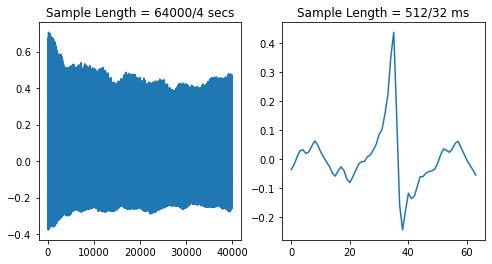

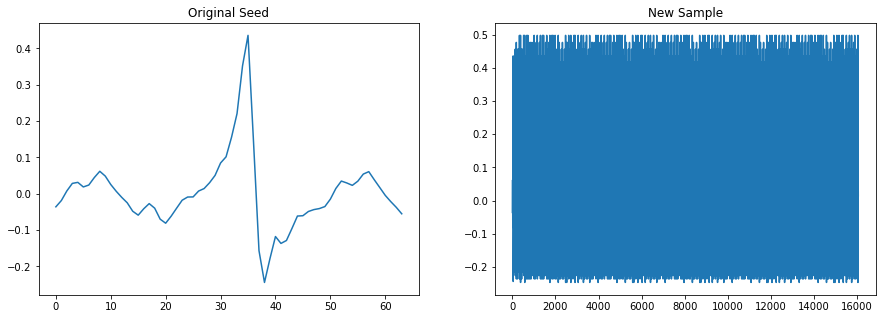

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


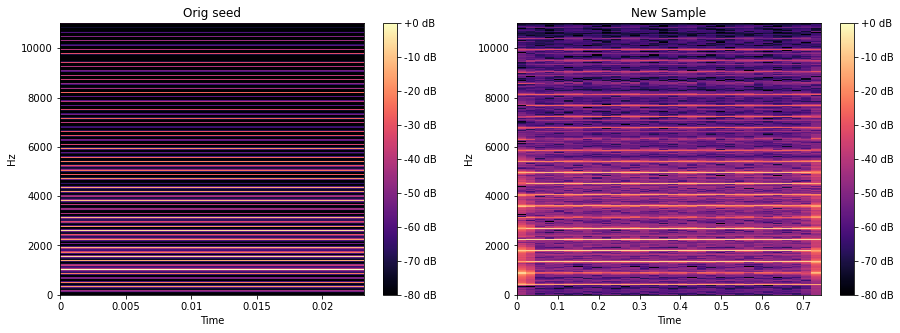

Time taken for sampling/plotting =  0:03:01


In [13]:
new_sample, orig_seed = sample_model('brass_acoustic_018-064-a.90', model=model, start_location=1, pitch=64, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

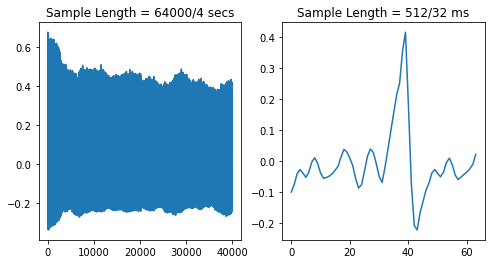

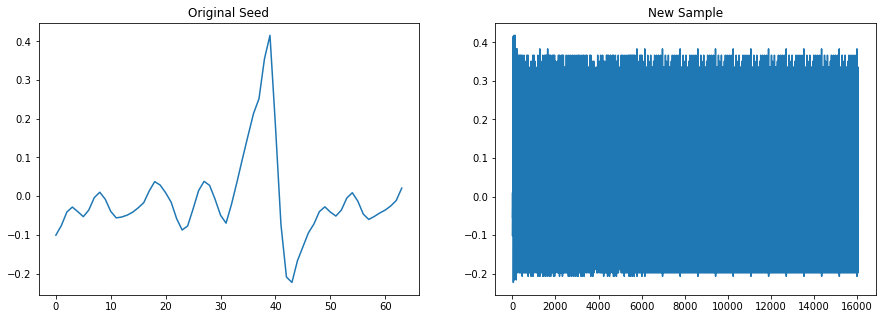

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


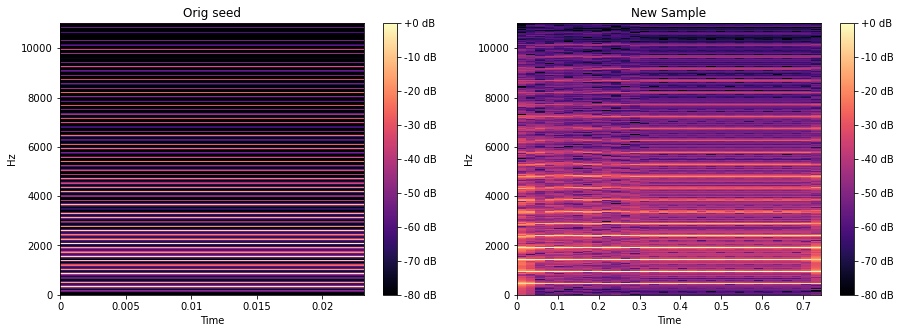

Time taken for sampling/plotting =  0:03:20


In [14]:
new_sample, orig_seed = sample_model('brass_acoustic_018-065-a.90', model=model, start_location=1, pitch=65, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

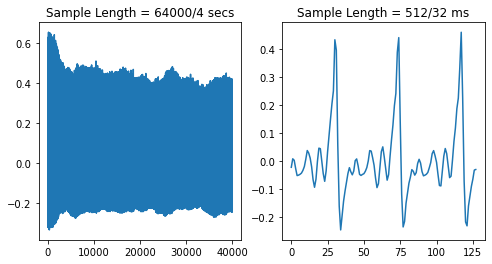

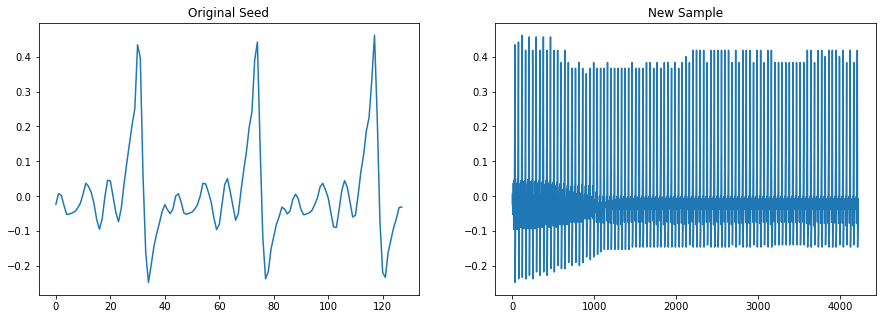

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=128
  warnings.warn(


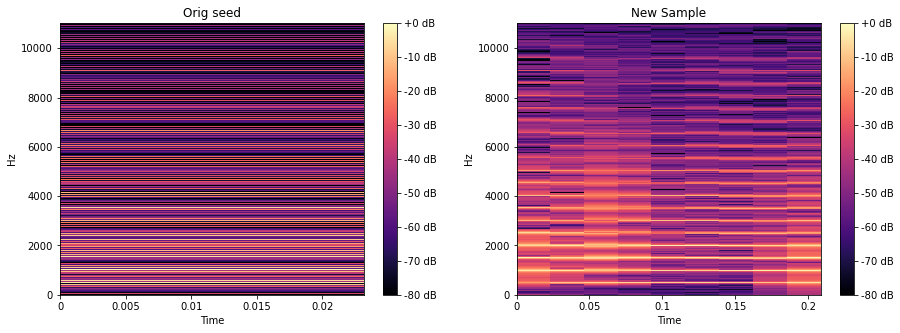

Time taken for sampling/plotting =  0:00:51


In [22]:
new_sample, orig_seed = sample_model('brass_acoustic_018-066-a.90', model=model, start_location=1, pitch=66, amplitude_scale=0.9, instrument_id=0, seq_len=4096)

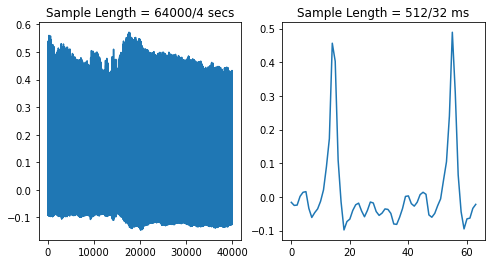

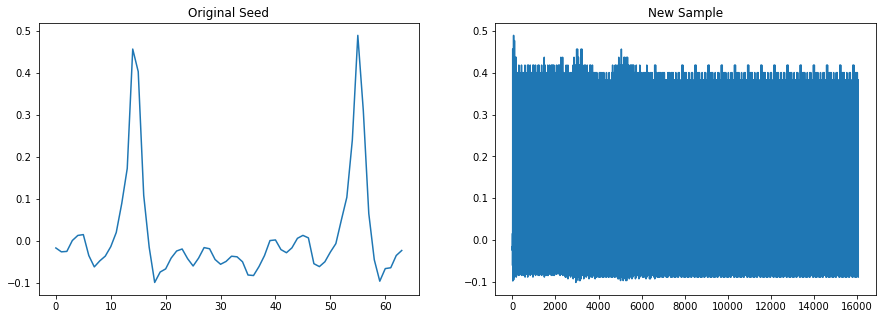

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


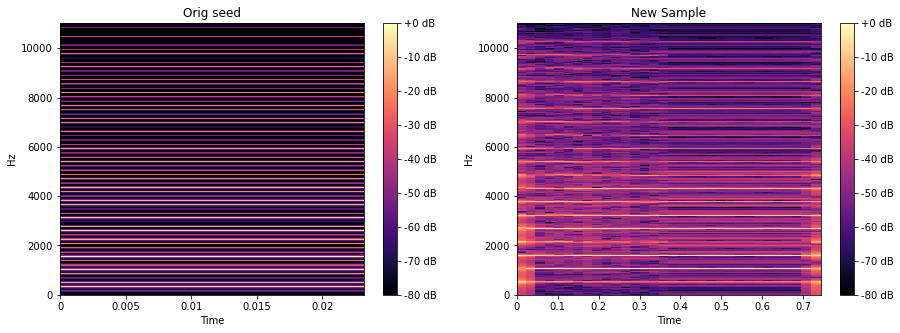

Time taken for sampling/plotting =  0:03:21


In [16]:
new_sample, orig_seed = sample_model('brass_acoustic_018-067-a.90', model=model, start_location=1, pitch=67, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

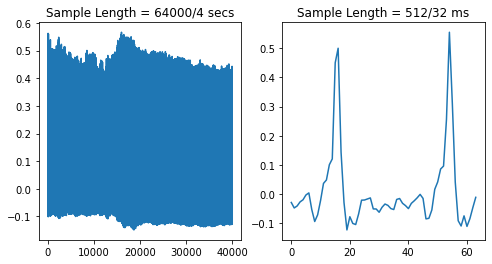

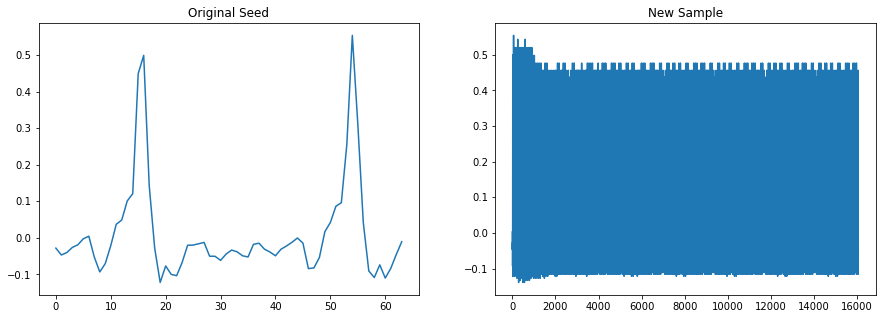

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


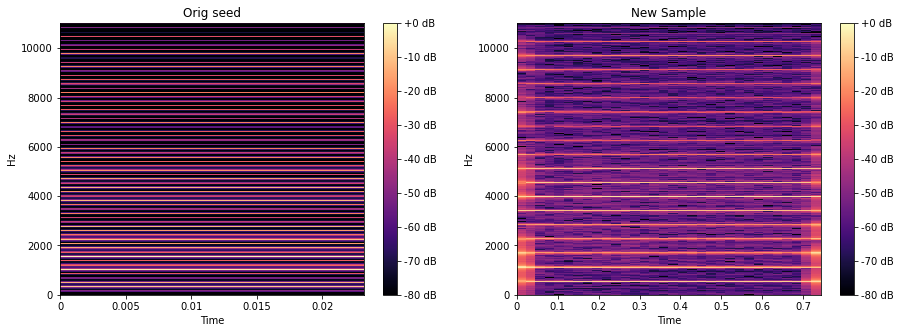

Time taken for sampling/plotting =  0:03:21


In [17]:
new_sample, orig_seed = sample_model('brass_acoustic_018-068-a.90', model=model, start_location=1, pitch=68, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

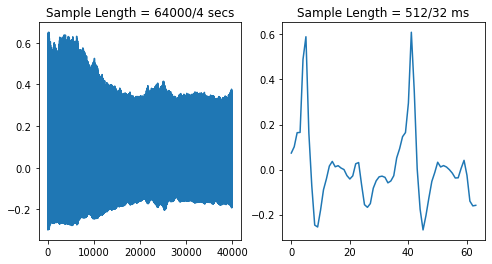

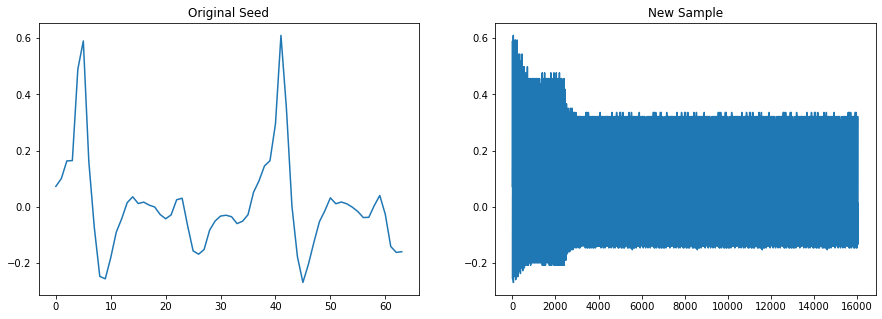

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


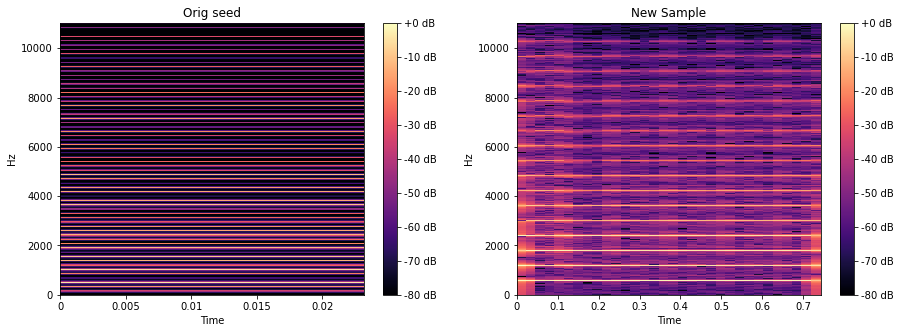

Time taken for sampling/plotting =  0:03:22


In [18]:
new_sample, orig_seed = sample_model('brass_acoustic_018-069-a.90', model=model, start_location=0.25, pitch=69, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

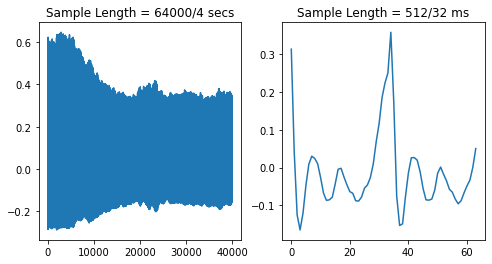

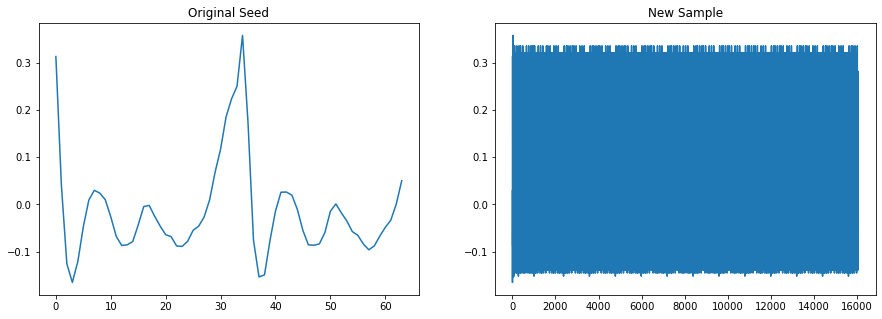

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


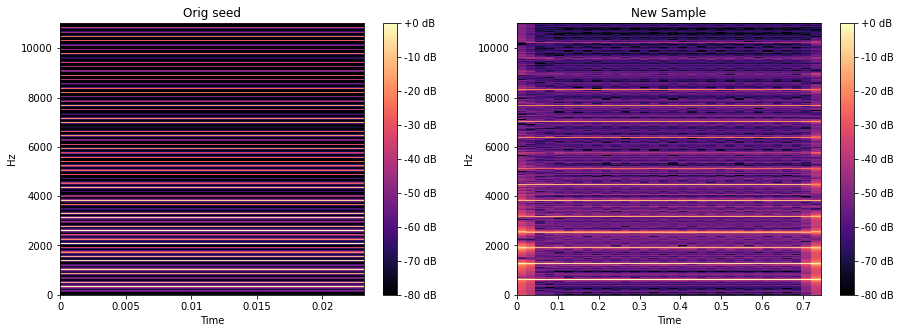

Time taken for sampling/plotting =  0:03:22


In [19]:
new_sample, orig_seed = sample_model('brass_acoustic_018-070-a.90', model=model, start_location=1, pitch=70, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

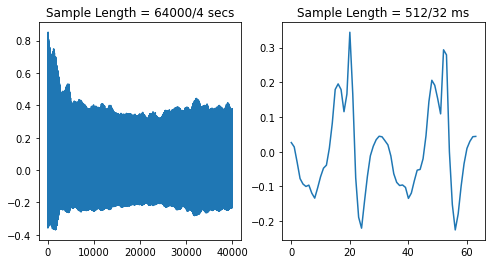

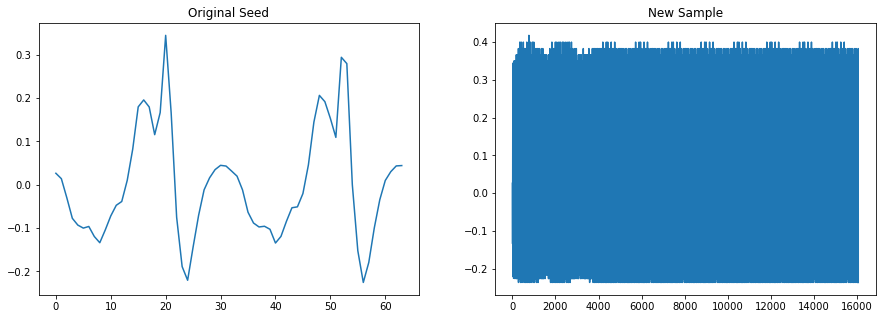

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


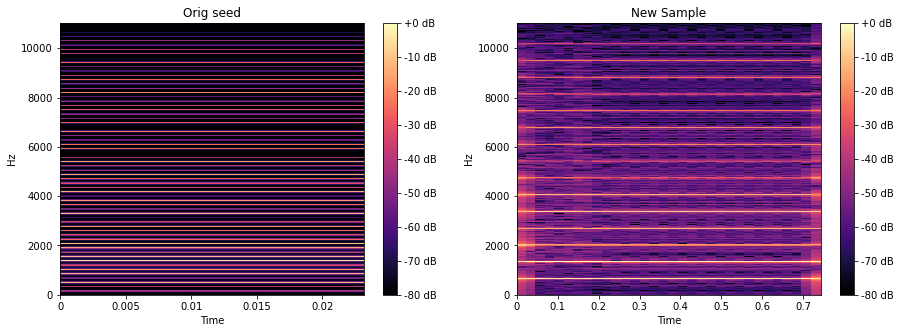

Time taken for sampling/plotting =  0:03:22


In [20]:
new_sample, orig_seed = sample_model('brass_acoustic_018-071-a.90', model=model, start_location=1, pitch=71, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

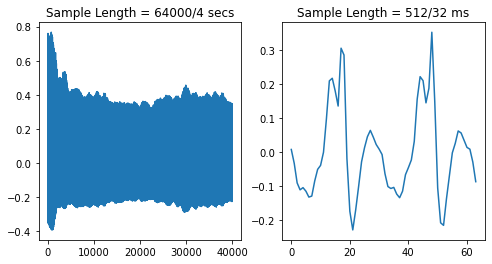

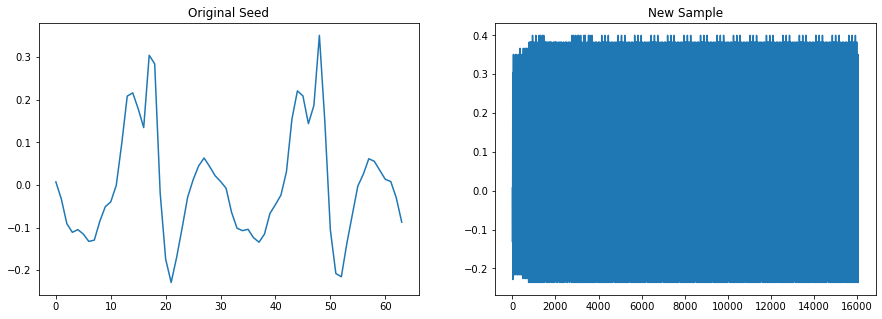

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


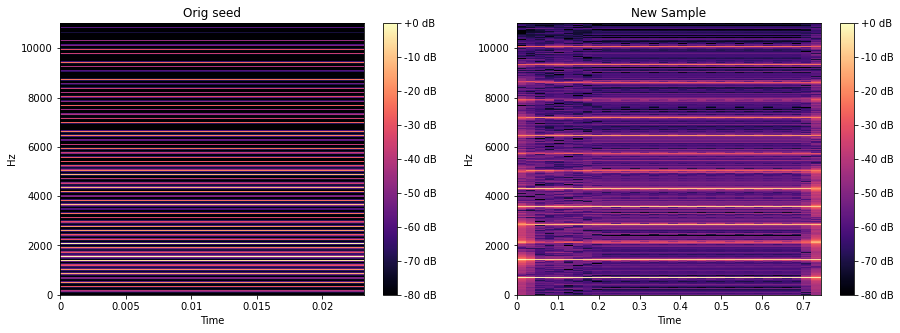

Time taken for sampling/plotting =  0:03:23


In [21]:
new_sample, orig_seed = sample_model('brass_acoustic_018-072-a.90', model=model, start_location=1, pitch=72, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

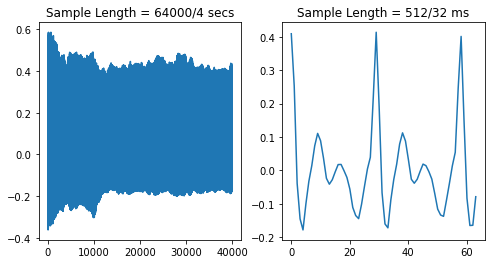

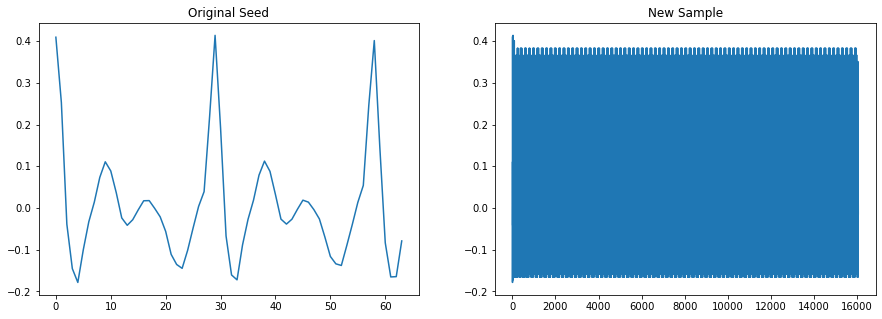

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


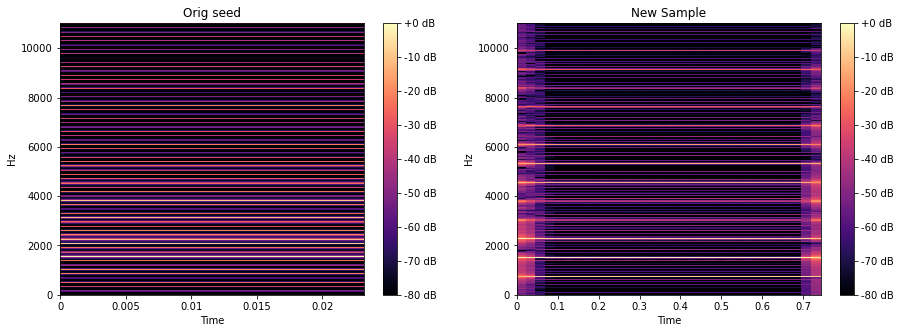

Time taken for sampling/plotting =  0:03:23


In [22]:
new_sample, orig_seed = sample_model('brass_acoustic_018-073-a.90', model=model, start_location=1, pitch=73, amplitude_scale=0.9, instrument_id=0, seq_len=16000)

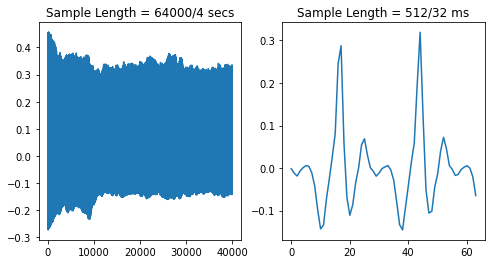

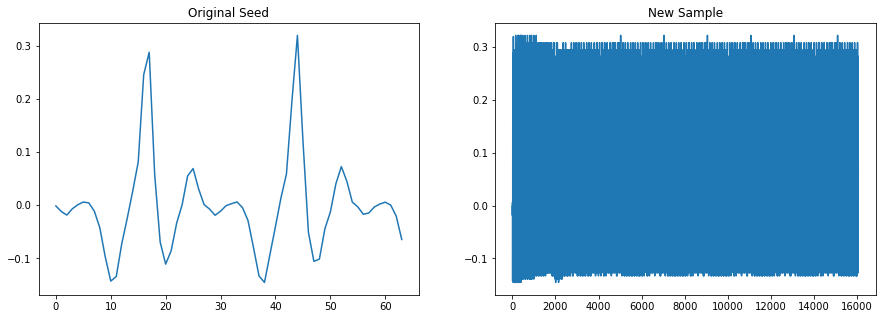

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


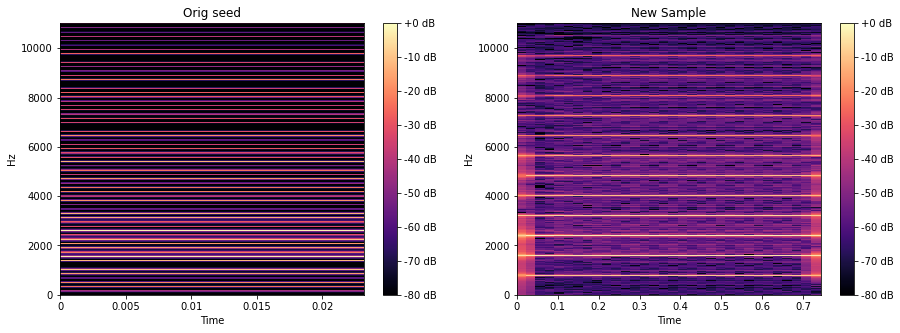

Time taken for sampling/plotting =  0:03:20


In [23]:
# new_sample, orig_seed = sample_model('brass_acoustic_018-074-a.90', model=model, start_location=0.25, pitch=74, amplitude_scale=0.9, instrument_id=0, seq_len=16000)
new_sample, orig_seed = sample_model('brass_acoustic_018-074-a.70', model=model, start_location=1, pitch=74, amplitude_scale=0.7, instrument_id=0, seq_len=16000)

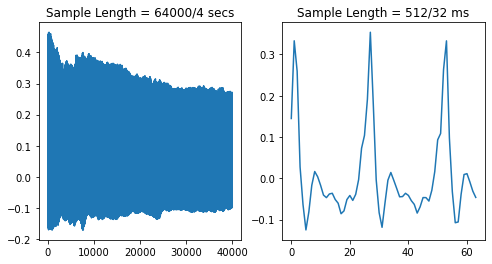

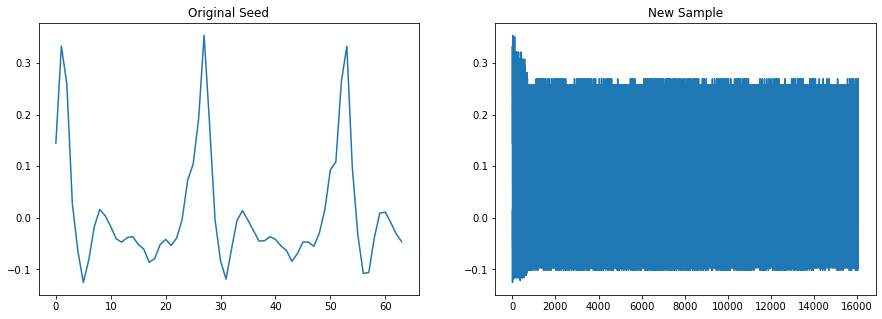

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


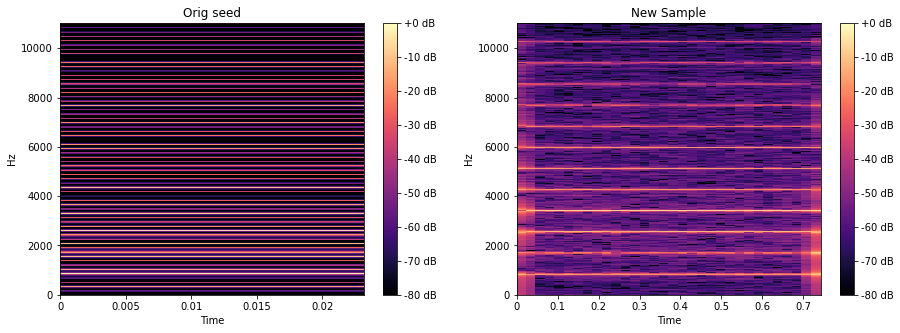

Time taken for sampling/plotting =  0:03:22


In [24]:
new_sample, orig_seed = sample_model('brass_acoustic_018-075-a.70', model=model, start_location=1, pitch=75, amplitude_scale=0.7, instrument_id=0, seq_len=16000)

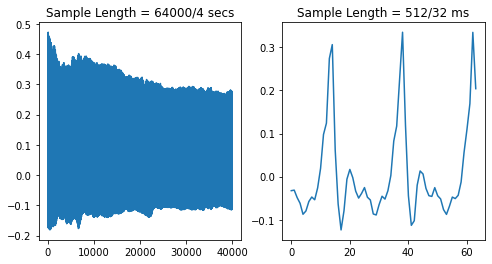

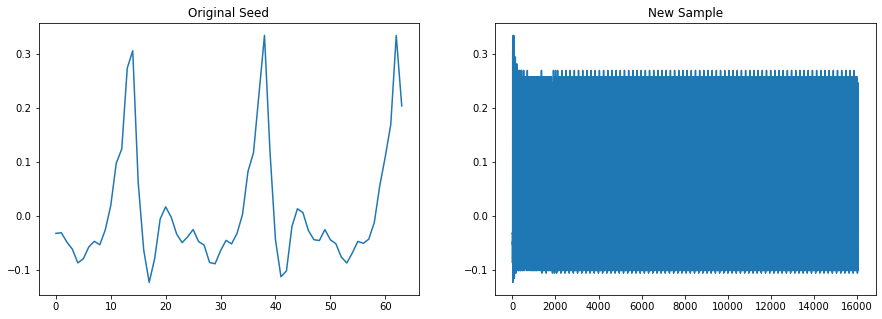

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


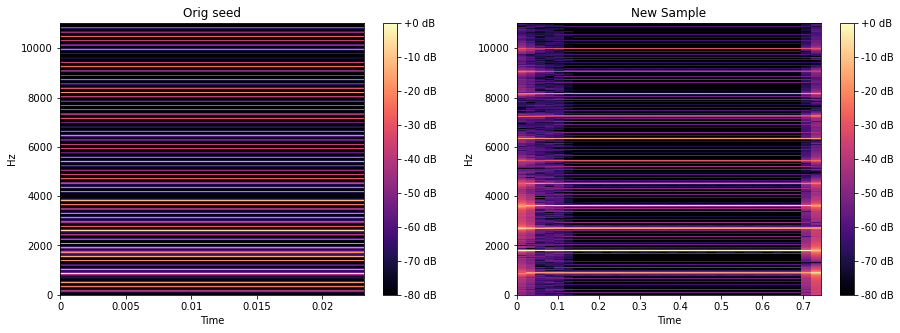

Time taken for sampling/plotting =  0:03:23


In [25]:
new_sample, orig_seed = sample_model('brass_acoustic_018-076-a.70', model=model, start_location=1, pitch=76, amplitude_scale=0.7, instrument_id=0, seq_len=16000)

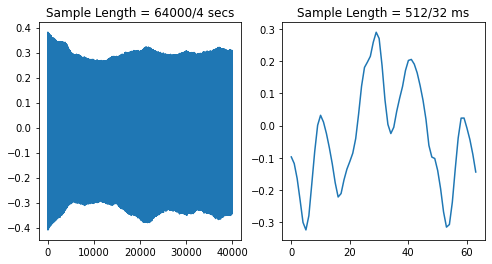

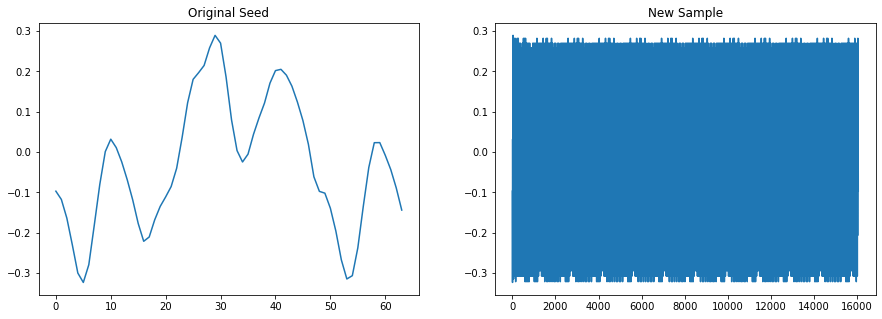

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


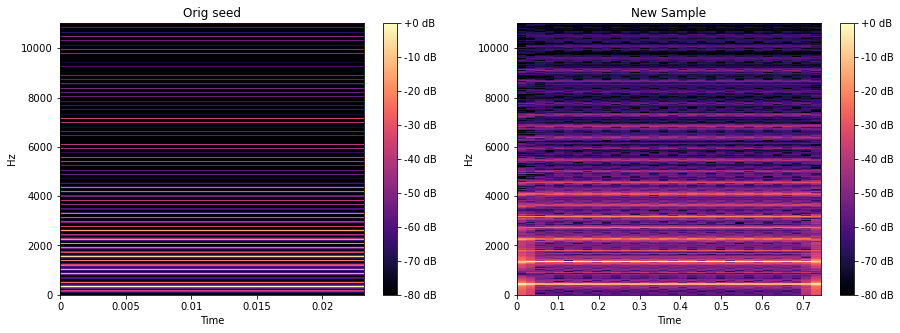

Time taken for sampling/plotting =  0:03:20


In [26]:
new_sample, orig_seed = sample_model('reed_acoustic_000-064-a.90', model=model, start_location=1, pitch=64, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

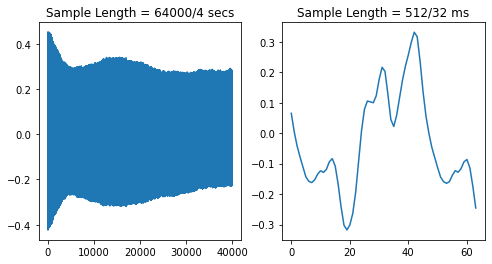

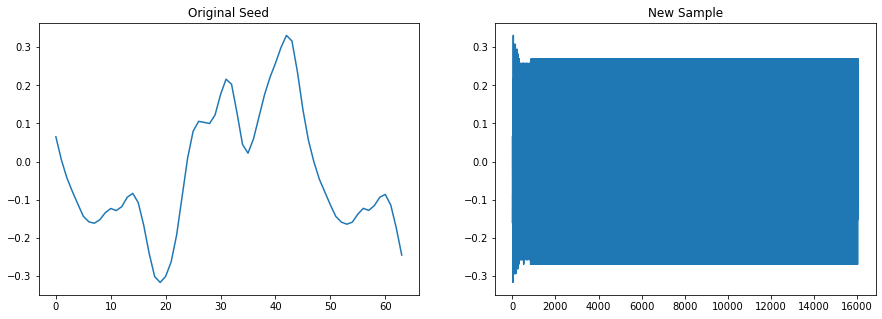

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


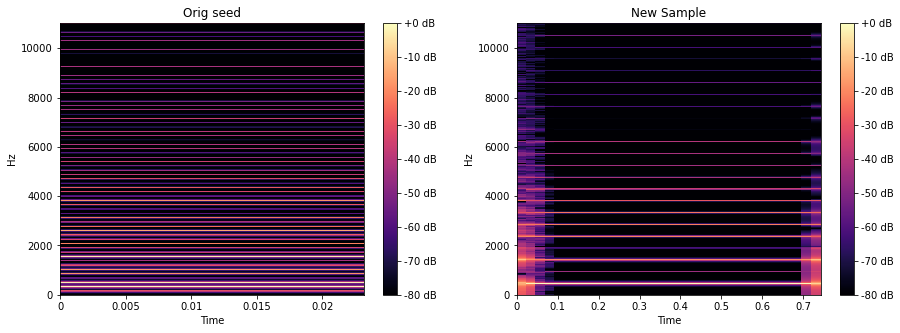

Time taken for sampling/plotting =  0:03:21


In [27]:
new_sample, orig_seed = sample_model('reed_acoustic_000-065-a.90', model=model, start_location=1, pitch=65, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

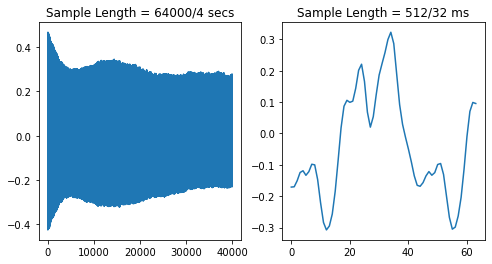

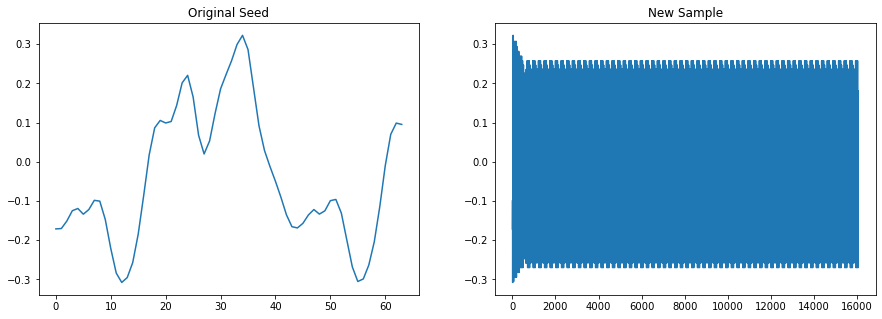

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


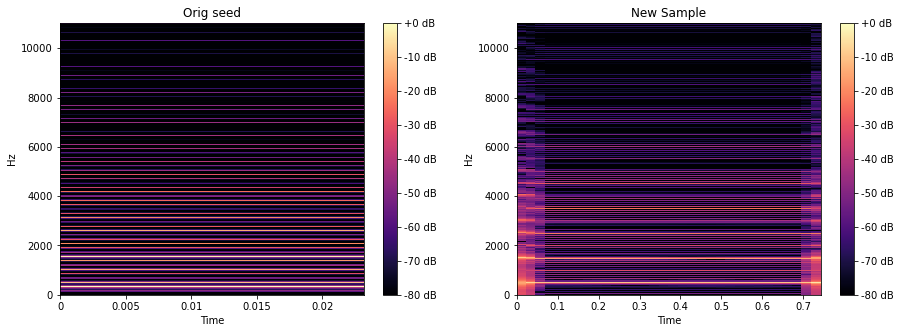

Time taken for sampling/plotting =  0:03:19


In [28]:
new_sample, orig_seed = sample_model('reed_acoustic_000-066-a.90', model=model, start_location=1, pitch=66, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

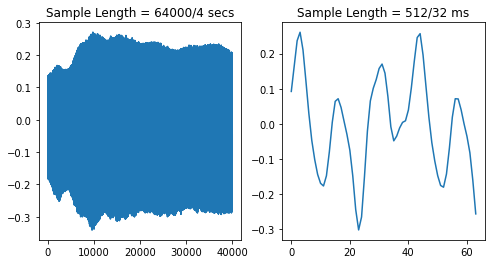

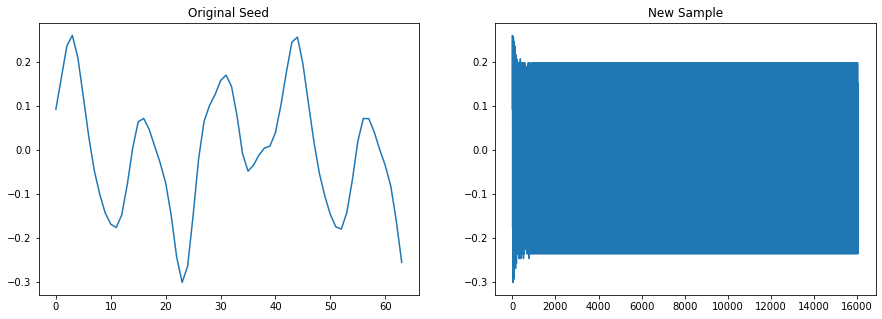

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


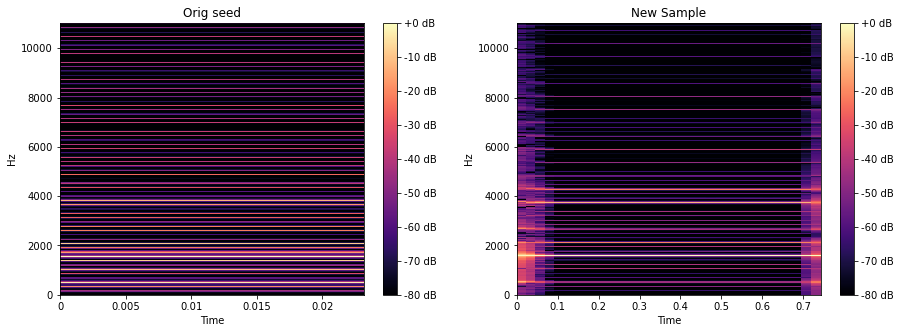

Time taken for sampling/plotting =  0:03:20


In [29]:
new_sample, orig_seed = sample_model('reed_acoustic_000-067-a.70', model=model, start_location=1, pitch=67, amplitude_scale=0.7, instrument_id=1, seq_len=16000)

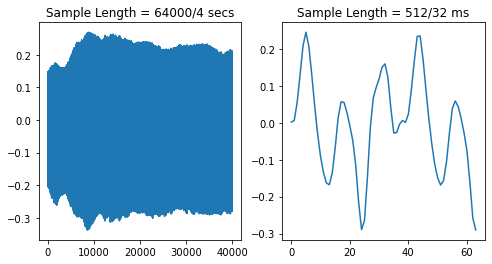

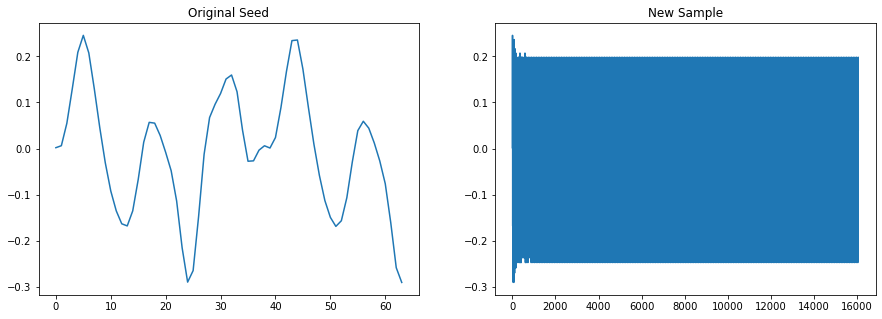

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


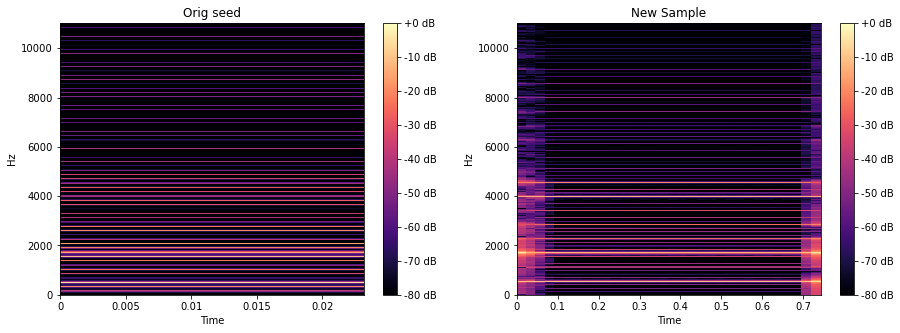

Time taken for sampling/plotting =  0:02:46


In [30]:
new_sample, orig_seed = sample_model('reed_acoustic_000-068-a.70', model=model, start_location=1, pitch=68, amplitude_scale=0.7, instrument_id=1, seq_len=16000)

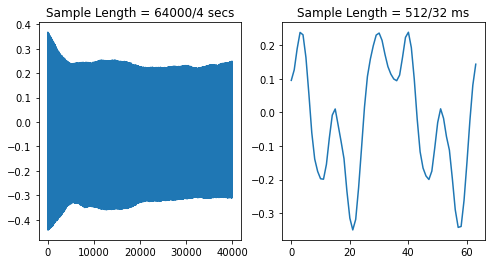

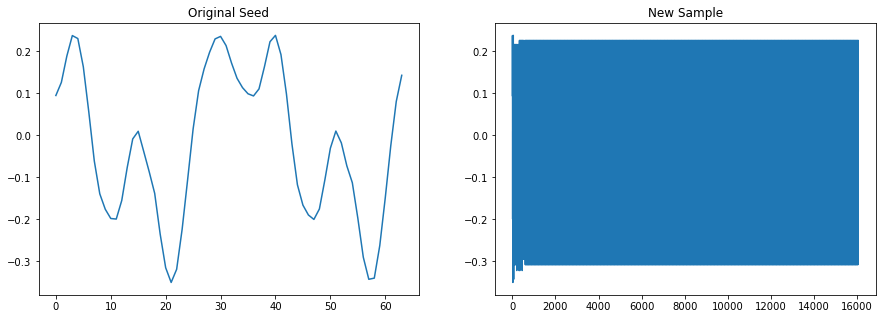

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


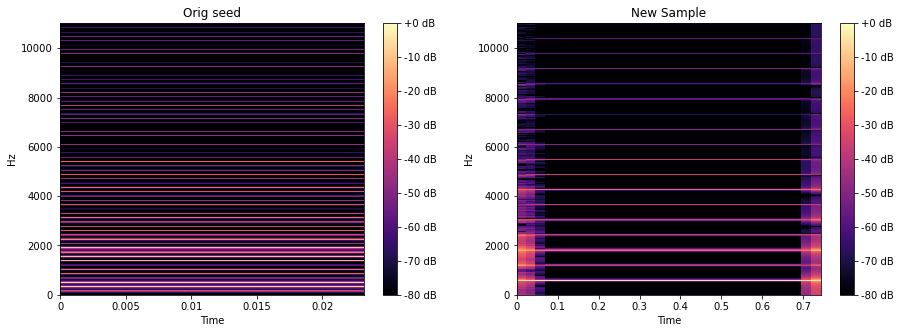

Time taken for sampling/plotting =  0:02:32


In [31]:
new_sample, orig_seed = sample_model('reed_acoustic_000-069-a.90', model=model, start_location=1.1, pitch=69, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

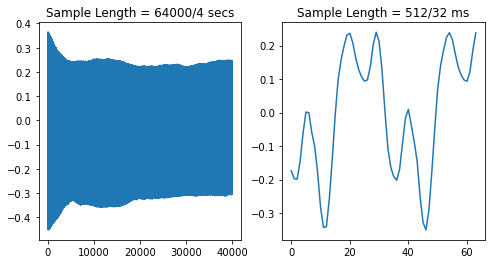

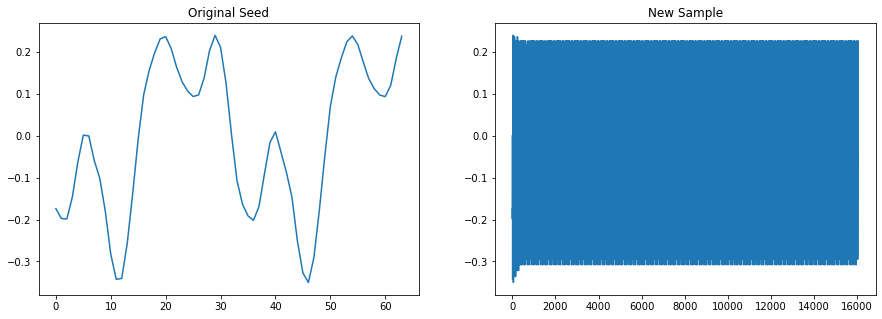

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


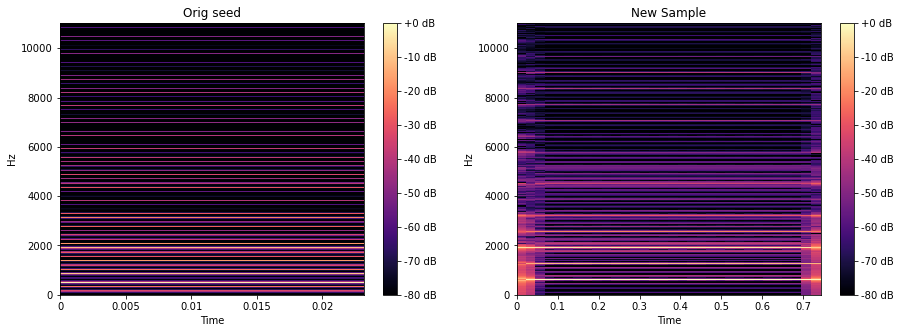

Time taken for sampling/plotting =  0:02:33


In [32]:
new_sample, orig_seed = sample_model('reed_acoustic_000-070-a.90', model=model, start_location=1, pitch=70, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

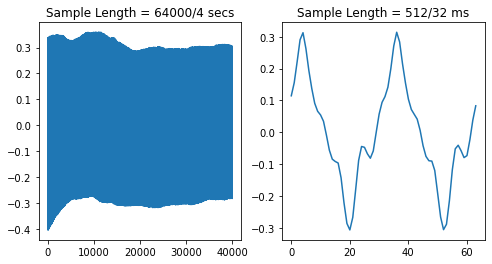

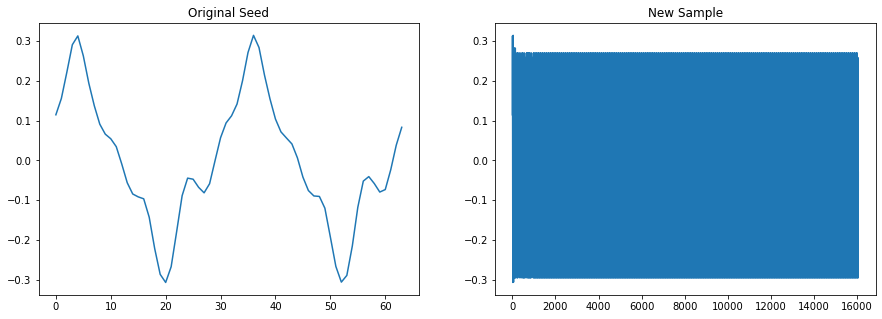

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


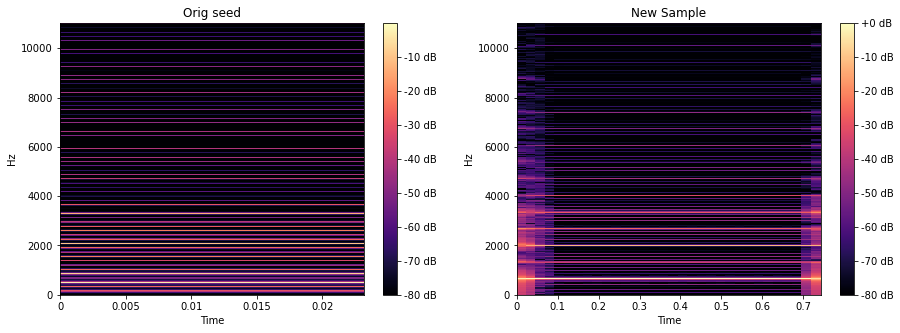

Time taken for sampling/plotting =  0:02:30


In [33]:
new_sample, orig_seed = sample_model('reed_acoustic_000-071-a.90', model=model, start_location=1, pitch=71, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

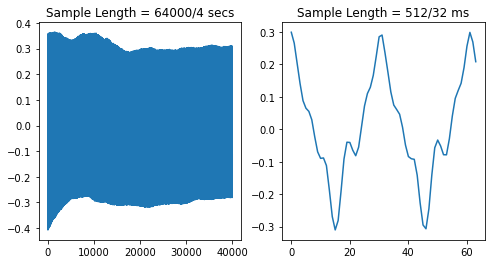

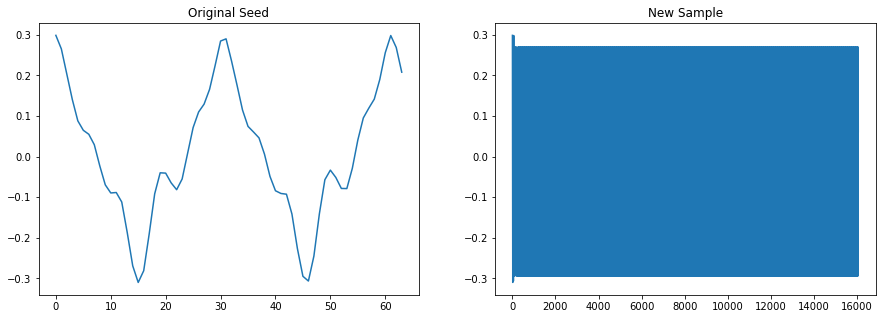

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


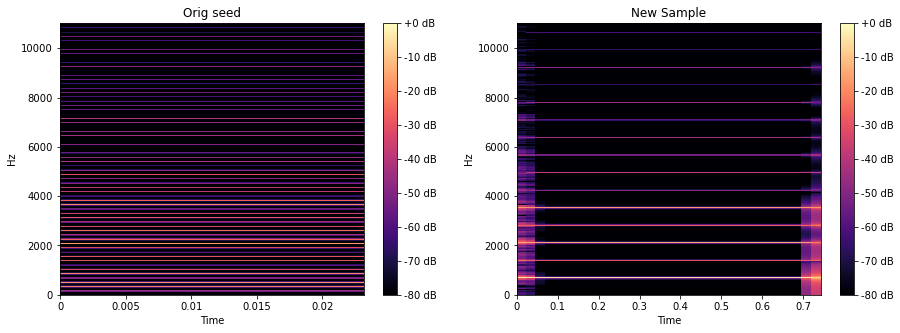

Time taken for sampling/plotting =  0:02:32


In [34]:
new_sample, orig_seed = sample_model('reed_acoustic_000-072-a.90', model=model, start_location=1, pitch=72, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

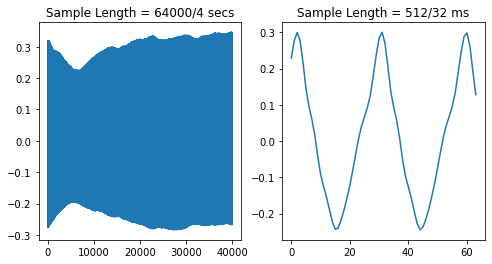

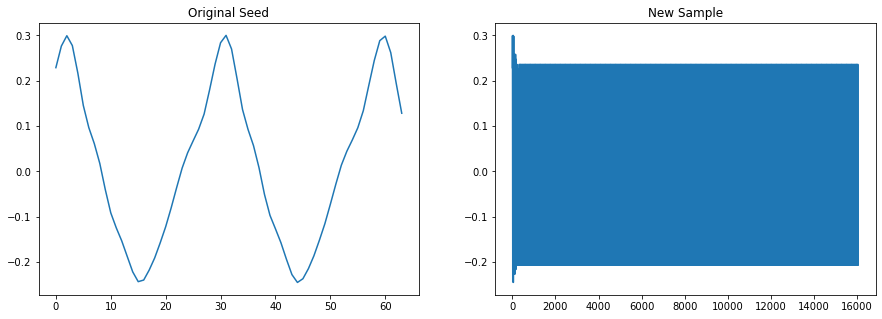

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


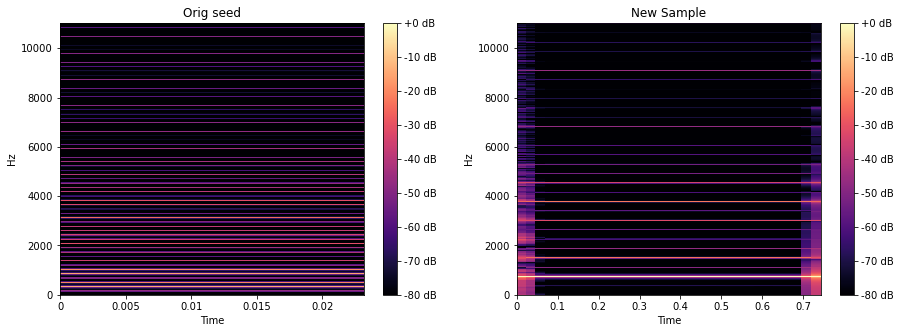

Time taken for sampling/plotting =  0:02:31


In [35]:
new_sample, orig_seed = sample_model('reed_acoustic_000-073-a.90', model=model, start_location=1, pitch=73, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

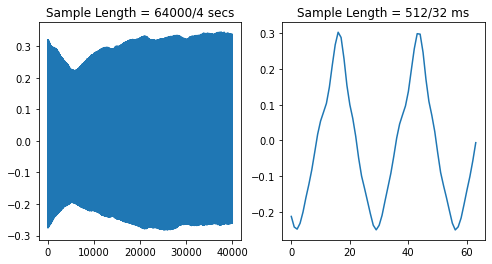

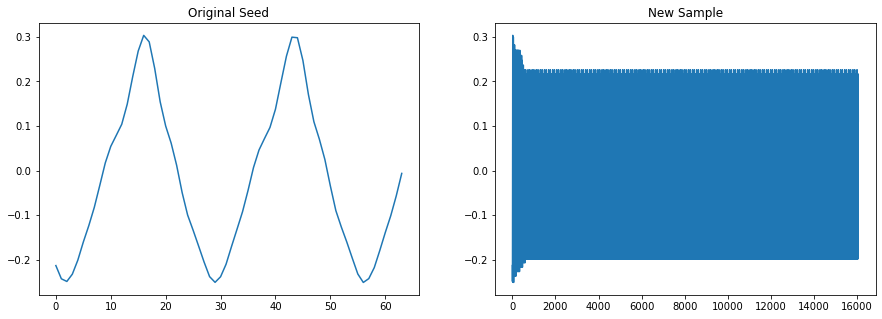

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


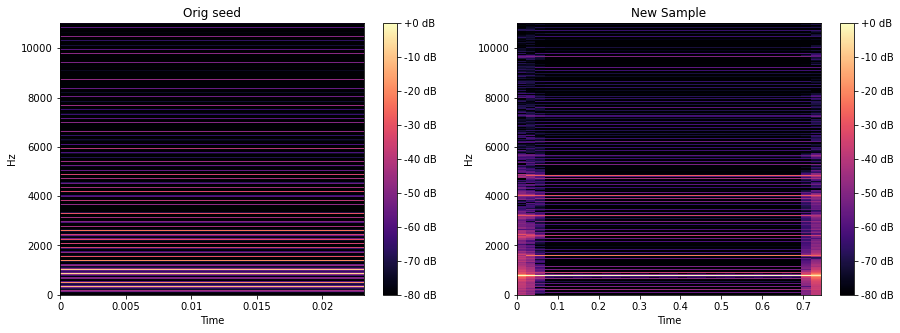

Time taken for sampling/plotting =  0:02:31


In [36]:
new_sample, orig_seed = sample_model('reed_acoustic_000-074-a.90', model=model, start_location=1, pitch=74, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

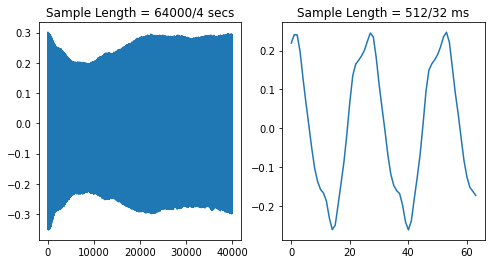

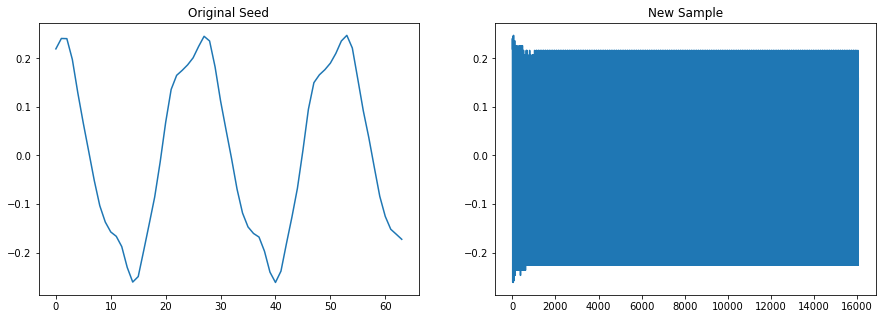

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


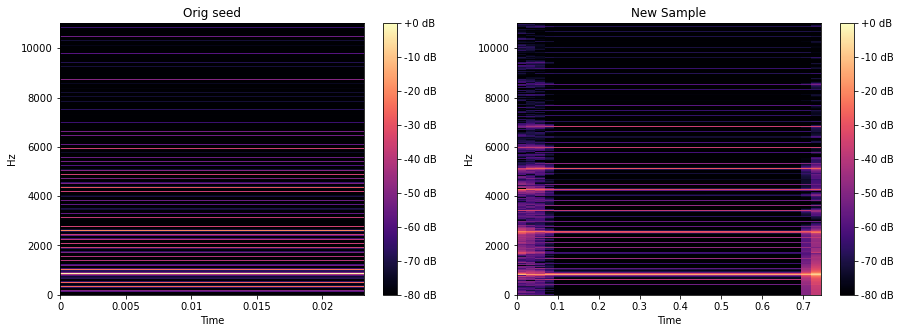

Time taken for sampling/plotting =  0:02:33


In [37]:
new_sample, orig_seed = sample_model('reed_acoustic_000-075-a.90', model=model, start_location=1, pitch=75, amplitude_scale=0.9, instrument_id=1, seq_len=16000)

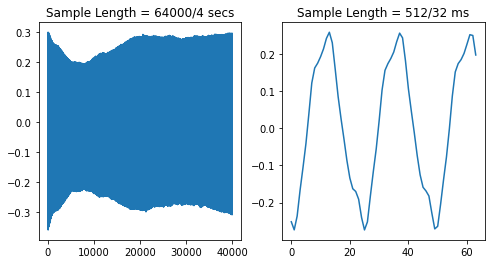

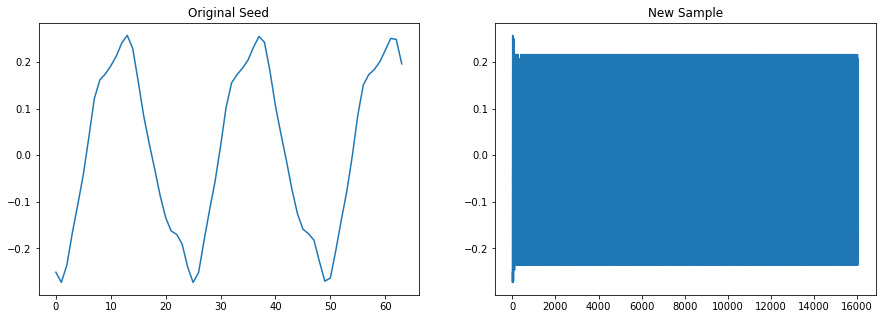

/home/purnima/anaconda3/envs/pDL/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=64
  warnings.warn(


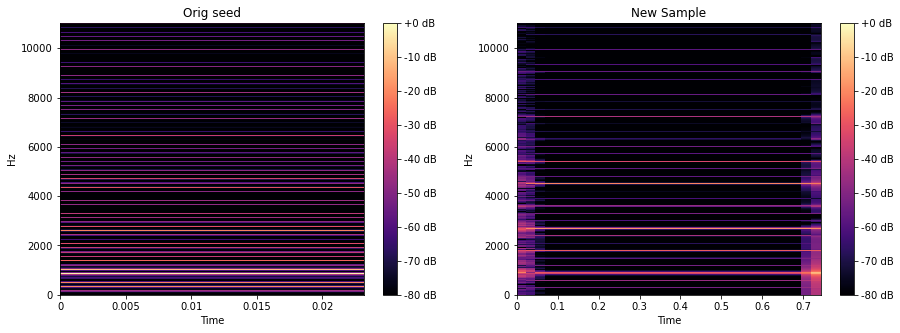

Time taken for sampling/plotting =  0:02:29


In [38]:
new_sample, orig_seed = sample_model('reed_acoustic_000-076-a.90', model=model, start_location=1, pitch=76, amplitude_scale=0.9, instrument_id=1, seq_len=16000)